https://webnautes.tistory.com/1658

In [5]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

import xgboost
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

if os.name == 'posix': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif os.name == 'nt': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

# 시드 고정

In [2]:
CFG = {
    'SEED':42
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED'])

# Load Data

In [3]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train = train_data.drop(['TARGET'], axis=1)
train_labels = train_data['TARGET']

display(train_data.head(3))
display(test_data.head(3))
display(train.head(3))
display(train_labels)

,ID,월,요일,시간,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,안개,짙은안개,번개,진눈깨비,서리,연기/연무,눈날림,범죄발생지,TARGET
0,TRAIN_00000,9,화요일,10,137,8.0,2.611124,0.0,0.0,0.0,245.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,2
1,TRAIN_00001,11,화요일,6,438,13.0,3.209093,0.0,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,0
2,TRAIN_00002,8,일요일,6,1729,47.0,1.619597,0.0,0.0,0.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,인도,1


,ID,월,요일,시간,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,안개,짙은안개,번개,진눈깨비,서리,연기/연무,눈날림,범죄발생지
0,TEST_00000,9,금요일,5,927,28.0,1.570654,19.625000,0.0,0.0,165.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,차도
1,TEST_00001,5,수요일,3,926,28.0,1.712457,21.444444,0.0,0.0,175.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,식당
2,TEST_00002,5,월요일,6,1437,33.0,0.447496,25.200000,0.0,0.0,290.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,주거지


,ID,월,요일,시간,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,안개,짙은안개,번개,진눈깨비,서리,연기/연무,눈날림,범죄발생지
0,TRAIN_00000,9,화요일,10,137,8.0,2.611124,0.0,0.0,0.0,245.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도
1,TRAIN_00001,11,화요일,6,438,13.0,3.209093,0.0,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도
2,TRAIN_00002,8,일요일,6,1729,47.0,1.619597,0.0,0.0,0.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,인도


0        2
1        0
2        1
3        1
4        2
        ..
84401    1
84402    0
84403    0
84404    1
84405    0
Name: TARGET, Length: 84406, dtype: int64

# EDA

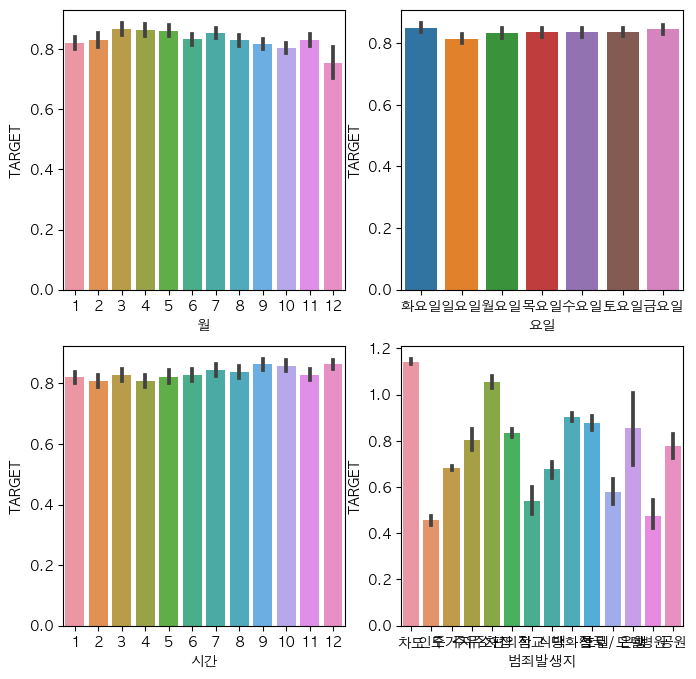

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()

features = ['월', '요일', '시간', '범죄발생지']
for i, feature in enumerate(features):
    sns.barplot(data=train_data, x=feature, y='TARGET', ax=axes[i])
        
plt.show()

# Pipe line

In [7]:
# 1. ID Drop하기
# 2. ['월', '요일', '시간', '범죄발생지']를 OneHotEncoder

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

class ID_Dropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        return X.drop('ID', axis=1)

class Features_OHE(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X_OHE = pd.get_dummies(X[['월', '요일', '시간', '범죄발생지']])
        X = pd.concat([X, X_OHE], axis=1)
        return X.drop(['월', '요일', '시간', '범죄발생지'], axis=1)

In [9]:
final_pipeline = Pipeline([
    ('ID_Dropper', ID_Dropper()),
    ('Features_OHE', Features_OHE()),
])

final_pipeline

Pipeline(steps=[('ID_Dropper', ID_Dropper()), ('Features_OHE', Features_OHE())])

In [10]:
train_prepared = final_pipeline.fit_transform(train)

display(train_prepared.head(3))
display(train_labels)

,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,안개,짙은안개,번개,...,범죄발생지_약국,범죄발생지_은행,범죄발생지_인도,범죄발생지_주거지,범죄발생지_주유소,범죄발생지_주차장,범죄발생지_차도,범죄발생지_편의점,범죄발생지_학교,범죄발생지_호텔/모텔
0,137,8.0,2.611124,0.0,0.0,0.0,245.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
1,438,13.0,3.209093,0.0,0.0,0.0,200.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
2,1729,47.0,1.619597,0.0,0.0,0.0,40.0,1.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0


0        2
1        0
2        1
3        1
4        2
        ..
84401    1
84402    0
84403    0
84404    1
84405    0
Name: TARGET, Length: 84406, dtype: int64

# Sample Weights

In [11]:
def CreateBalancedSampleWeights(y_train, largest_class_weight_coef):
    classes = y_train.unique()
    classes.sort()
    class_samples = np.bincount(y_train)
    total_samples = class_samples.sum()
    n_classes = len(class_samples)
    weights = total_samples / (n_classes * class_samples * 1.0)
    class_weight_dict = {key : value for (key, value) in zip(classes, weights)}
    class_weight_dict[classes[1]] = class_weight_dict[classes[1]] * largest_class_weight_coef
    sample_weights = [class_weight_dict[y] for y in y_train]

    return sample_weights

train_prepared_SW = CreateBalancedSampleWeights(train_labels, largest_class_weight_coef=1)
train_prepared_SW[:3]

[1.2473547319264644, 0.7718249069578178, 1.1078211337297057]

# Train Test Split

In [12]:
X_train, X_val, y_train, y_val = train_test_split(train_prepared, train_labels,
                                                    test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(67524, 35) (16882, 35) (67524,) (16882,)


# XGB

In [39]:
model = XGBClassifier(n_estimators=9115,
                      max_depth=12,
                      min_child_weight=192,
                      gamma=1,
                      learning_rate=0.007863074143203265,
                      colsample_bytree=0.6654080735911255,
                      alpha=1.2782120935572674)

In [ ]:
model.fit(train_prepared, train_labels)

# Inference

In [ ]:
preds = model.predict(final_pipeline.fit_transform(test_data))

In [ ]:
submit = pd.read_csv('sample_submission.csv')

In [ ]:
submit['TARGET'] = preds
submit.head()

In [ ]:
submit.to_csv('0530_2.csv', index=False)